# Red Teaming Segment Anything
## Mask robustness in different weather conditions

Due to license of Cityscapes dataset, the dataset needs to be constructed separately and cannot be shared in this notebook. Instructions how to construct the dataset are present here: https://github.com/vnmusat/multi-weather-city

In [ ]:
# Remember to change depending on whether using on Colab or not.
# If run locally the notebook assumes that the datasets and libraries have been already installed,
# if not the lines from get_colab_dependencies should be done once.
USING_COLAB = True
GDRIVE_DATASET_ID = 'cannot be shared due to license of Cityscapes dataset'

In [ ]:
import sys
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm

In [ ]:
def get_colab_dependencies(using_colab: bool) -> None:
    """
    If using_colab is set to True, then the dependencies will be installed.
    The function assumes that the model checkpoint and the dataset are already present locally, if not then the function should be called to download all the necessary data.
    """
    if using_colab:
        !{sys.executable} -m pip install opencv-python matplotlib
        !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
        # download the vit model
        !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
        # get Cityscapes_multi_weather dataset using gdown
        !{sys.executable} -m pip install gdown
        !mkdir multi-weather-city
        # remember to put id from your Google drive
        !gdown --id f"GDRIVE_DATASET_ID" -O Cityscapes_multi_weather.zip
        !mv Cityscapes_multi_weather.zip ./multi-weather-city/Cityscapes_multi_weather.zip
        !unzip ./multi-weather-city/Cityscapes_multi_weather.zip -d ./multi-weather-city
        !rm ./multi-weather-city/Cityscapes_multi_weather.zip

        from google.colab import drive
        # Mount Google Drive to Colab (optional)
        drive.mount('/gdrive')

In [ ]:
get_colab_dependencies(USING_COLAB)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.modeling import Sam

In [ ]:
def get_image(path: str) -> np.ndarray:
    """
    Function to load the image from the path and convert it to RGB format.
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def show_image(image: np.ndarray, figsize: Tuple[int, int] = (5, 5)) -> None:
    """
    Function to show the image. Useful for debugging.
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
def get_sam(sam_checkpoint: str = "sam_vit_h_4b8939.pth", model_type: str = "vit_h") -> Sam:
    """
    Getter function to make the code cleaner. Segment Anything model is loaded and moved to GPU if available.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    return sam

In [ ]:
def find_center_of_mask(mask: np.ndarray) -> Tuple[int, int]:
    """
    Function finds the center (mean of x and y coordinates) of the mask. If the center lays outside the mask, then the closest point in mask is returned.
    """
    mask_indices = np.where(mask)
    y_center = int(np.mean(mask_indices[0]))
    x_center = int(np.mean(mask_indices[1]))
    # if point not in mask find the closest point in mask
    if not mask[x_center][y_center]:
        y_center = mask_indices[0][np.argmin(np.abs(mask_indices[0] - y_center))]
        x_center = mask_indices[1][np.argmin(np.abs(mask_indices[1] - x_center))]

    return x_center, y_center

In [ ]:
MAX_COLORS = 256
RANDOM_COLORS = np.random.random((MAX_COLORS, 3))


def show_masks(image: np.ndarray,
               image_title: str,
               masks: List[np.ndarray],
               points: List[Tuple[int, int]],
               top_k=None,
               figsize: Tuple[int, int] = (4, 4),
               display: bool = True) -> None:
    """
    Function to display the masks and points of interest on the image.
    If top_k is not specified, all masks will be displayed.
    Masks will be displayed only if display is set to True.
    """
    if len(masks) == 0 or not display:
        return

    if top_k is None:
        top_k = len(masks)

    plt.figure(figsize=figsize)
    plt.imshow(image)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((np.squeeze(masks[0]).shape[0], np.squeeze(masks[0]).shape[1], 4))
    img[:, :, 3] = 0
    for i, m in enumerate(masks[:top_k]):
        color_mask = np.concatenate([RANDOM_COLORS[i], [0.35]])
        m = np.squeeze(m)  # there is an extra dimension when masking from point prompt
        img[m] = color_mask

    points_x = [p[0] for p in points[:top_k]]
    points_y = [p[1] for p in points[:top_k]]
    ax.imshow(img)
    ax.scatter(points_x, points_y, s=100, c="red", marker="x")
    ax.set_axis_off()
    plt.title(f"{image_title} masks")
    plt.show()

In [ ]:
def save_masks(main_image_masks: List[np.ndarray],
               conditions_masks: Dict[str, List[np.ndarray]],
               output_path: str,
               conditions: List[str]) -> None:
    """
    Function to save the masks for each condition and the main image.
    Masks are converted to numpy arrays for performance and easier saving.
    """
    assert output_path.endswith('.npz'), "Output path should end with .npz"

    np_main_image_masks = np.stack(main_image_masks, axis=0)
    np_conditions_masks = np.stack([np.stack(value, axis=0) for key, value in conditions_masks.items()], axis=0)
    np_conditions_names = np.array(conditions)
    np.savez(output_path, main_image_masks=np_main_image_masks, conditions_masks=np_conditions_masks,
             conditions=np_conditions_names)


def load_masks(input_path: str) -> Tuple[List[np.ndarray], Dict[str, List[np.ndarray]]]:
    """
    Function to load the masks from the npz file.
    Converts the stored data from numpy format to format used in the code.
    """
    assert input_path.endswith('.npz'), "Input path should end with .npz"

    npzfile = np.load(input_path)
    main_image_masks = npzfile['main_image_masks']
    conditions_masks = npzfile['conditions_masks']
    conditions_names = npzfile['conditions']

    ret_main_image_masks: List[np.ndarray] = [mask for mask in main_image_masks]
    ret_conditions_masks: Dict[str, List[np.ndarray]] = {}
    for i, condition in enumerate(conditions_names):
        ret_conditions_masks[condition] = [mask for mask in conditions_masks[i]]

    return ret_main_image_masks, ret_conditions_masks

In [ ]:
def get_masks_from_points(image: np.ndarray,
                          points: List[Tuple[int, int]],
                          predictor: SamPredictor,
                          k=None) -> List[np.ndarray]:
    """
    Function to get the masks from the points of interest. If k is not specified, all points will be used,
    otherwise k masks will be returned. An image is set for the predictor to calculate the embedding only once
    for optimization purposes.
    """
    if k is None:
        k = len(points)
    final_masks = []
    predictor.set_image(image)
    for i, point in enumerate(points[:k]):
        masks, _, _ = predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([1]),
            multimask_output=True,
        )
        masks_areas = np.sum(masks, axis=(1, 2))
        mask = masks[np.argmax(masks_areas)]  # heuristic - choose the biggest area

        final_masks.append(mask)
    return final_masks

In [ ]:
def get_iou(mask1: np.ndarray, mask2: np.ndarray) -> np.ndarray:
    """
    Function to calculate the IoU between two masks. Masks are expected to be in the format (N, H, W).
    """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection, axis=(1, 2)) / np.sum(union, axis=(1, 2))
    return iou_score


def get_mean_iou(masks1: List[np.ndarray], masks2: List[np.ndarray]) -> np.ndarray:
    """
    Function to calculate the mean IoU between two lists of masks. masks are converted to numpy arrays for performance reasons.
    """
    assert len(masks1) == len(masks2)

    np_masks1 = np.stack(masks1, axis=0)
    np_masks2 = np.stack(masks2, axis=0)

    ious = get_iou(np_masks1, np_masks2)
    assert ious.shape == (len(np_masks1),)

    return np.mean(ious)

In [ ]:
def histogram_of_mean_ious(mean_ious_results: Dict[str, List[float]],
                           num_cols: int = 2,
                           fig_size: Tuple[int, int] = (10, 10)) -> None:
    """
    Function to display the histogram of mean IoUs for each condition.
    """
    num_conditions = len(mean_ious_results)
    num_columns = num_cols
    num_rows = (num_conditions + num_columns - 1) // num_columns  # Calculate the number of rows

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=fig_size)

    for i, (condition, mean_ious) in enumerate(mean_ious_results.items()):
        mean_of_mean_ious = np.mean(mean_ious)
        print(f'Mean IoU for condition {condition} is {mean_of_mean_ious:.4f}')

        # Plot histogram on the i-th subplot
        row, col = divmod(i, num_columns)
        condition = condition.replace('Cityscapes_', '')

        if num_rows == 1:
          axes[col].hist(mean_ious, range=(0, 1))
          axes[col].axvline(mean_of_mean_ious, color='red', linestyle='dashed', linewidth=1)
          axes[col].set_title(f'Condition: {condition}\nMean: {mean_of_mean_ious:.2f}')
        else:
          axes[row, col].hist(mean_ious, range=(0, 1))
          axes[row, col].axvline(mean_of_mean_ious, color='red', linestyle='dashed', linewidth=1)
          axes[row, col].set_title(f'Condition: {condition}\nMean: {mean_of_mean_ious:.2f}')

    # Remove last subplots
    for i in range(len(mean_ious_results.items()), num_columns * num_rows):
        row, col = divmod(i, num_columns)
        axes[row, col].set_axis_off()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [ ]:
def experiment(points_filenames_path: Path,
               main_images_filenames_path: Path,
               k_points: int,
               city: str,
               display: bool = False,
               num_files: Optional[int] = None):
    """
    Enables conducting many experiments with different value as they might be treated as hyperparameters and various input directories. Save the computed masks for later use.
    """
    if num_files is None:
        num_files = len(list(points_filenames_path.glob('*.png')))

    # check if directory results exists or create
    results_dir = Path('./gdrive/results')
    if not results_dir.exists():
        results_dir.mkdir(parents=True)

    # Prepare model and predictors.
    sam = get_sam()
    automatic_mask_generator = SamAutomaticMaskGenerator(sam)
    predictor = SamPredictor(sam)

    benchmark_images_filenames = list(points_filenames_path.glob('*.png'))[:num_files]  # list for tqdm
    main_images_filenames = list(main_images_filenames_path.glob('*.png'))[:num_files]  # list for tqdm

    mean_ious_results: Dict[str, List[np.ndarray]] = {key: [] for key in COMPARE_CONDITIONS}


    print(f'Starting benchmarking for city: {city} with {k_points} points of interest '
          f'coming from {str(points_filenames_path)} directory.')

    # main experiment loop
    for points_of_interest_path, main_image_path in tqdm(zip(benchmark_images_filenames, main_images_filenames)):
        print(f'Points for benchmarking masks will be taken from path: {points_of_interest_path}')
        points_of_interest_image = get_image(str(points_of_interest_path))
        original_masks = automatic_mask_generator.generate(points_of_interest_image)
        sorted_masks = sorted(original_masks, key=lambda m: m['area'], reverse=True)
        masks: List[np.ndarray] = [m['segmentation'] for m in sorted_masks]
        points = [find_center_of_mask(m) for m in masks]
        show_masks(points_of_interest_image, 'Point proposals and ', masks, points, k_points, display=display)
        # At this point we have the points of interest for the image.

        print(f'Calculating masks for main image: {main_image_path}')
        main_image = get_image(str(main_image_path))
        main_image_masks = get_masks_from_points(main_image, points, predictor, k_points)
        show_masks(points_of_interest_image, f'main image ', main_image_masks, points, k_points, display=display)

        # Now we can calculate the masks for other conditions
        print(f'Calculating masks for {len(COMPARE_CONDITIONS)} conditions for file {main_image_path.name}')

        conditions_masks: Dict[str, List[np.ndarray]] = {}
        for condition in COMPARE_CONDITIONS:
            condition_image_path = Path(PREFIX_DIR) / condition / 'leftImg8bit/train' / city / main_image_path.name
            condition_image = get_image(str(condition_image_path))
            condition_masks_from_points = get_masks_from_points(condition_image, points, predictor, k_points)
            show_masks(condition_image, f'{condition} ', condition_masks_from_points, points, k_points, display=display)
            # save if needed later
            conditions_masks[condition] = condition_masks_from_points

            # calculate mean iou
            mean_iou = get_mean_iou(main_image_masks, condition_masks_from_points)
            mean_ious_results[condition].append(mean_iou)

        output_masks_filename = str(results_dir / Path(main_image_path.name).with_suffix('.npz'))
        save_masks(main_image_masks, conditions_masks, output_masks_filename, COMPARE_CONDITIONS)

    return mean_ious_results

### Main code for experiments

In [ ]:
PREFIX_DIR = './multi-weather-city/Cityscapes_multi_weather'
COMPARE_CONDITIONS = ['Cityscapes_night',
                      'Cityscapes_night_drops',
                      'Cityscapes_overcast_drops',
                      'Cityscapes_snow',
                      'Cityscapes_snow_drops',
                      'Cityscapes_wet',
                      'Cityscapes_wet_drops']
MAIN_DIR = str(Path(PREFIX_DIR) / 'Cityscapes_overcast/leftImg8bit/train')

# Different experiments values - hyperparameters.
# With this path we can test 2 methods of choosing points of interest: from image or ground truth masks from dataset.
POINTS_OF_INTEREST_PATH = MAIN_DIR # can be also: str(Path(PREFIX_DIR) / 'Cityscapes_overcast/gtFine/train')
CITY_DIR = 'aachen'
DEBUG = False
K = 9

In [ ]:
city = CITY_DIR
points_filenames_path = Path(POINTS_OF_INTEREST_PATH) / city
main_images_filenames_path = Path(MAIN_DIR) / city
mean_iou_results = experiment(points_filenames_path, main_images_filenames_path, K, city, display=DEBUG)

In [ ]:
import json

# Keep the masks to be used later
with open('mean_ious_results.json', 'w') as json_file:
    json.dump(mean_iou_results, json_file)

Mean IoU for condition Cityscapes_night is 0.7030
Mean IoU for condition Cityscapes_night_drops is 0.3896
Mean IoU for condition Cityscapes_overcast_drops is 0.7649
Mean IoU for condition Cityscapes_snow is 0.8707
Mean IoU for condition Cityscapes_snow_drops is 0.5439
Mean IoU for condition Cityscapes_wet is 0.7957
Mean IoU for condition Cityscapes_wet_drops is 0.5660


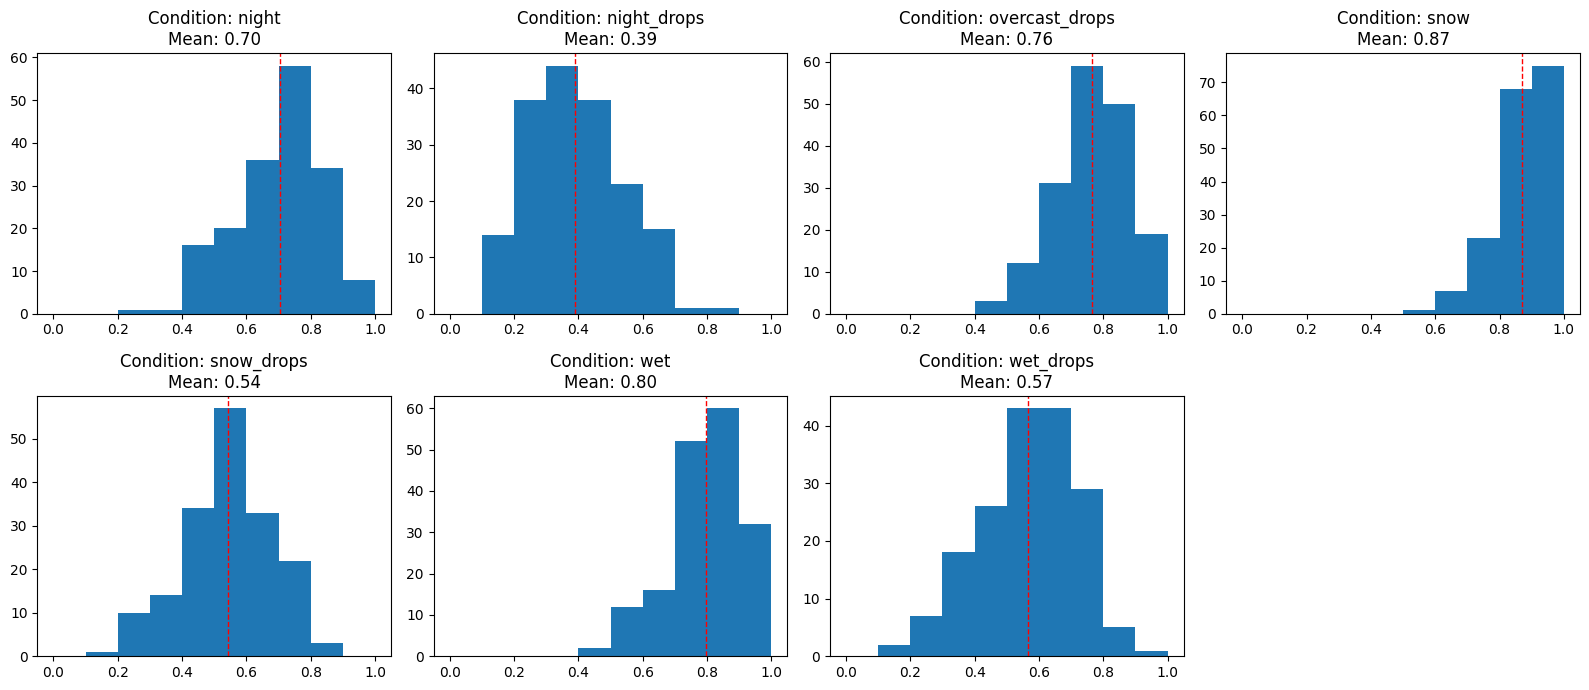

In [ ]:
histogram_of_mean_ious(mean_iou_results, num_cols=4, fig_size=(16, 7))